<a href="https://colab.research.google.com/github/jonelrelucio/AN2DL-2025/blob/testing/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import f1_score

SEED = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cpu


In [9]:
df_train = pd.read_csv('/content/drive/MyDrive/ANN/pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [4]:
df_labels = pd.read_csv('/content/drive/MyDrive/ANN/pirate_pain_train_labels.csv')
df_labels.head()



,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [5]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [6]:
df_merged = pd.merge(df_train, df_labels, on='sample_index')
df_merged.size

4336160

In [7]:
nan_counts = df_merged.isnull().sum()
display(nan_counts[nan_counts > 0])

,0


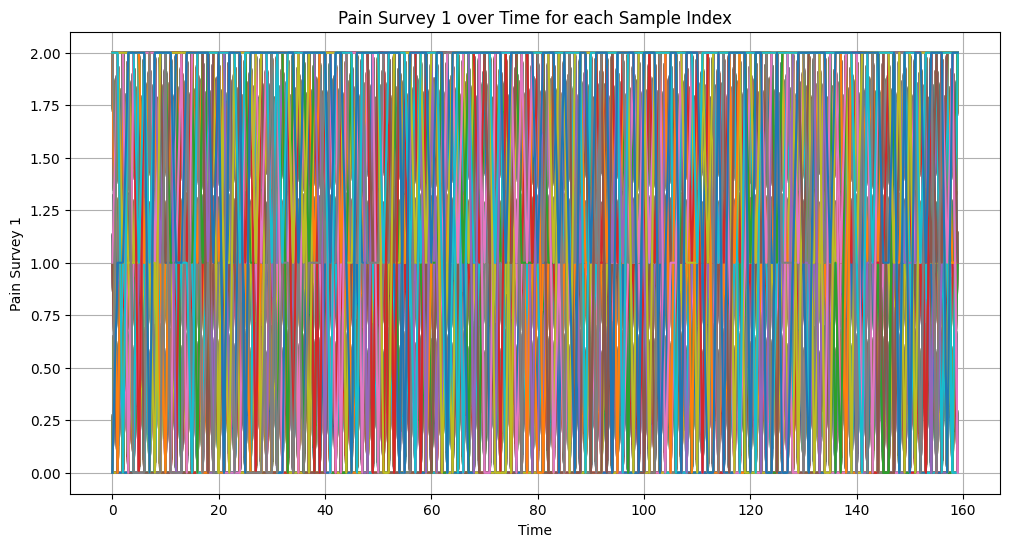

In [ ]:
plt.figure(figsize=(12, 6))
for sample_idx in df_merged['sample_index'].unique():
    subset = df_merged[df_merged['sample_index'] == sample_idx]
    plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for each Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

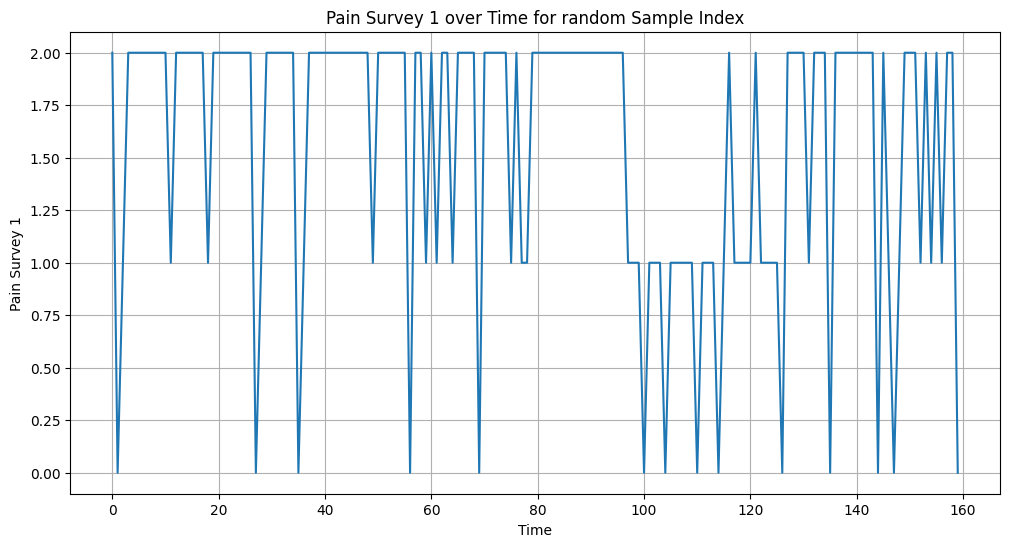

In [ ]:
plt.figure(figsize=(12, 6))
sample_idx = random.choice(df_merged['sample_index'].unique())
subset = df_merged[df_merged['sample_index'] == sample_idx]
plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for random Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

In [ ]:
label_counts = df_merged['n_legs'].value_counts()
display(label_counts)

,count
n_legs,
two,63441
one+peg_leg,800


In [ ]:
label_counts = df_merged['n_eyes'].value_counts()
display(label_counts)

,count
n_eyes,
two,63441
one+eye_patch,800


In [ ]:
label_counts = df_merged['n_hands'].value_counts()
display(label_counts)

,count
n_hands,
two,63441
one+hook_hand,800


In [ ]:
unusual_samples = df_merged[
    (df_merged['n_eyes'] != 'two') |
    (df_merged['n_legs'] != 'two') |
    (df_merged['n_hands'] != 'two')
]

display(unusual_samples[['sample_index', 'label']].drop_duplicates().reset_index(drop=True))

,sample_index,label
0,8,no_pain
1,137,no_pain
2,216,no_pain
3,338,low_pain
4,350,no_pain


In [ ]:
unusual_sample_indices = unusual_samples['sample_index'].unique()
unusual_labels = df_labels[df_labels['sample_index'].isin(unusual_sample_indices)]

display(unusual_labels)

,sample_index,label
8,8,no_pain
137,137,no_pain
216,216,no_pain
338,338,low_pain
350,350,no_pain


In [ ]:
df_unusual_first_timestamp = df_merged[
    (df_merged['sample_index'].isin(unusual_sample_indices)) &
    (df_merged['time'] == 0)
]
display(df_unusual_first_timestamp[['sample_index', 'n_legs', 'n_hands', 'n_eyes', 'label']])

,sample_index,n_legs,n_hands,n_eyes,label
1280,8,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
21920,137,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
34560,216,one+peg_leg,one+hook_hand,one+eye_patch,no_pain
54080,338,one+peg_leg,one+hook_hand,one+eye_patch,low_pain
56000,350,one+peg_leg,one+hook_hand,one+eye_patch,no_pain


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ANN/pirate_pain_test.csv')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float64
 10  joint_01       211840 non-null  float64
 11  joint_02       211840 non-null  float64
 12  joint_03       211840 non-null  float64
 13  joint_04       211840 non-null  float64
 14  joint_05       211840 non-null  float64
 15  joint_06       211840 non-null  float64
 16  joint_07       211840 non-null  float64
 17  joint_08       211840 non-nul

In [ ]:
df_test.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,...,211840.000000,211840.000000,2.118400e+05,2.118400e+05,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.0
mean,661.500000,79.500000,1.615384,1.665625,1.657501,1.663293,0.984106,1.002312,0.833719,0.839993,...,0.000032,0.000024,4.138805e-05,3.408469e-05,0.000107,0.040524,0.060134,0.052490,0.061218,0.5
std,382.206671,46.187228,0.703560,0.659999,0.666037,0.662678,0.204744,0.191175,0.298458,0.298573,...,0.001464,0.000413,5.570593e-04,6.285418e-04,0.001203,0.057234,0.078081,0.058698,0.066651,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036813,0.014754,0.047624,...,0.000002,0.000001,0.000000e+00,0.000000e+00,0.000000,0.000000,0.004475,0.004083,0.000000,0.5
25%,330.750000,39.750000,1.000000,2.000000,2.000000,2.000000,0.867980,0.897176,0.625202,0.604872,...,0.000003,0.000003,4.412668e-07,2.325231e-07,0.000000,0.010886,0.017376,0.020317,0.021007,0.5
50%,661.500000,79.500000,2.000000,2.000000,2.000000,2.000000,1.040931,1.063110,0.969119,0.979624,...,0.000004,0.000004,2.527479e-06,2.060598e-06,0.000006,0.022146,0.033317,0.035334,0.038696,0.5
75%,992.250000,119.250000,2.000000,2.000000,2.000000,2.000000,1.128461,1.139088,1.052242,1.060542,...,0.000006,0.000006,4.590578e-06,3.708785e-06,0.000014,0.046722,0.069825,0.061336,0.077690,0.5
max,1323.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.500341,1.499030,1.346970,1.333893,...,0.389906,0.062781,6.476609e-02,1.249919e-01,0.167318,1.299322,1.375895,1.412636,1.333794,0.5


In [ ]:
df_test['sample_index'].nunique()

1324

In [ ]:
unusual_samples = df_test[
    (df_test['n_eyes'] != 'two') |
    (df_test['n_legs'] != 'two') |
    (df_test['n_hands'] != 'two')
]

print(unusual_samples[['sample_index']].nunique())

df_unusual_first_timestamp = df_test[
    (df_test['sample_index'].isin(unusual_sample_indices)) &
    (df_test['time'] == 0)
]
display(df_unusual_first_timestamp[['sample_index', 'n_legs', 'n_hands', 'n_eyes']])

sample_index    13
dtype: int64


,sample_index,n_legs,n_hands,n_eyes
1280,8,two,two,two
21920,137,two,two,two
34560,216,two,two,two
54080,338,two,two,two
56000,350,two,two,two


In [ ]:
df_high = df_merged[df_merged['label'] == 'high_pain']
df_low = df_merged[df_merged['label'] == 'low_pain']
df_no = df_merged[df_merged['label'] == 'no_pain' ]

df_high.describe()
joint_columns = [c for c in df_merged.columns if c.startswith('joint_')]
joint_columns = joint_columns[:-1]
columns = ['time'] + joint_columns

df_high_mean = df_high[columns].mean()
df_low_mean = df_low[columns].mean()
df_no_mean = df_no[columns].mean()

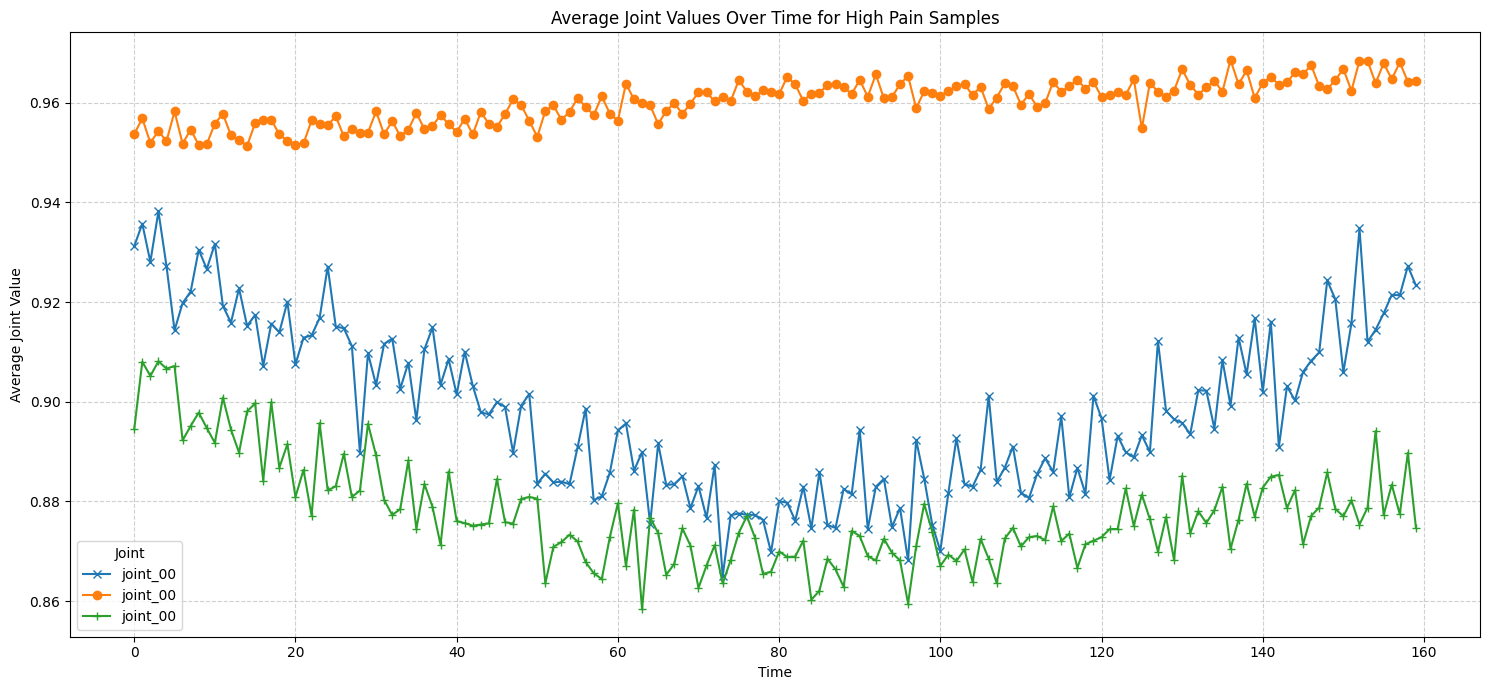

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [ ]:
df_high_time_evolution = df_high.groupby('time')[joint_columns].mean()
df_low_time_evolution = df_low.groupby('time')[joint_columns].mean()
df_no_time_evolution = df_no.groupby('time')[joint_columns].mean()
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_00']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

In [8]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_10']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

NameError: name 'df_high_time_evolution' is not defined

<Figure size 1500x700 with 0 Axes>

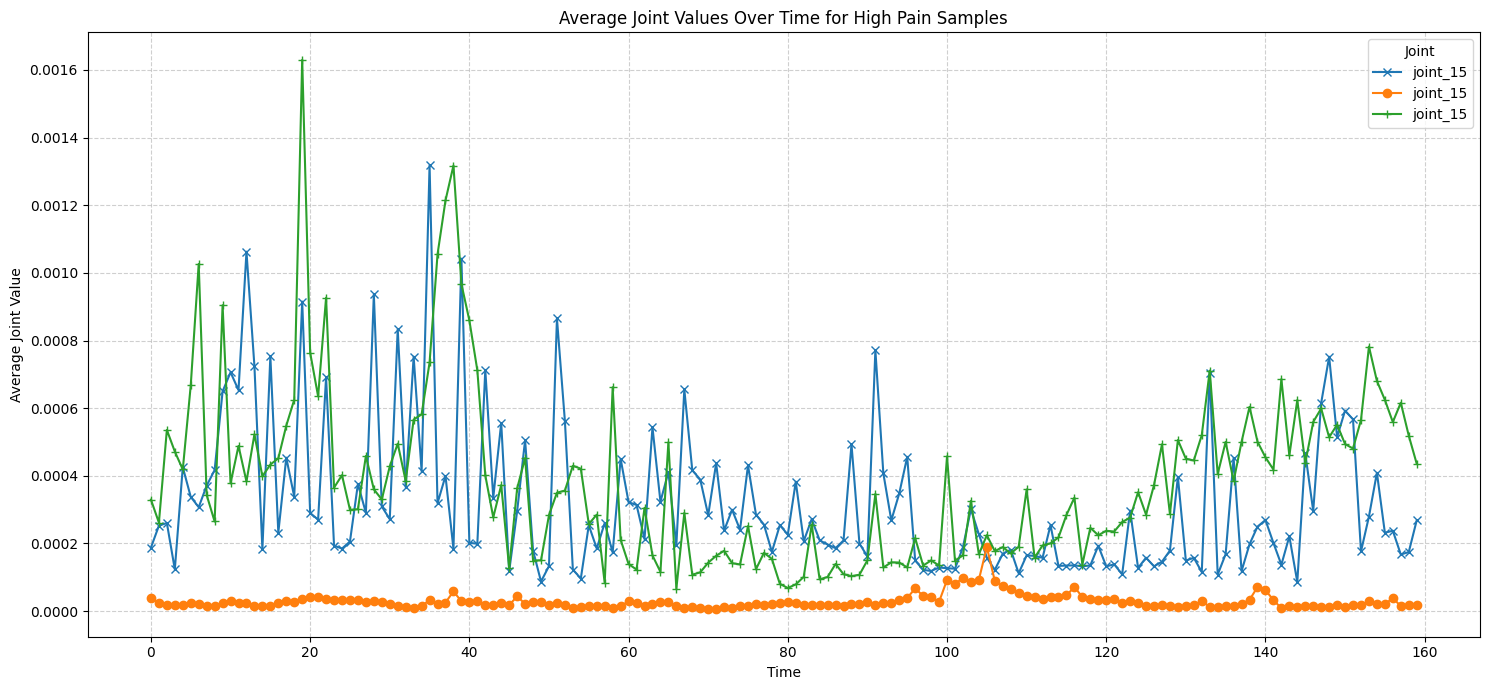

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [ ]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_15']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

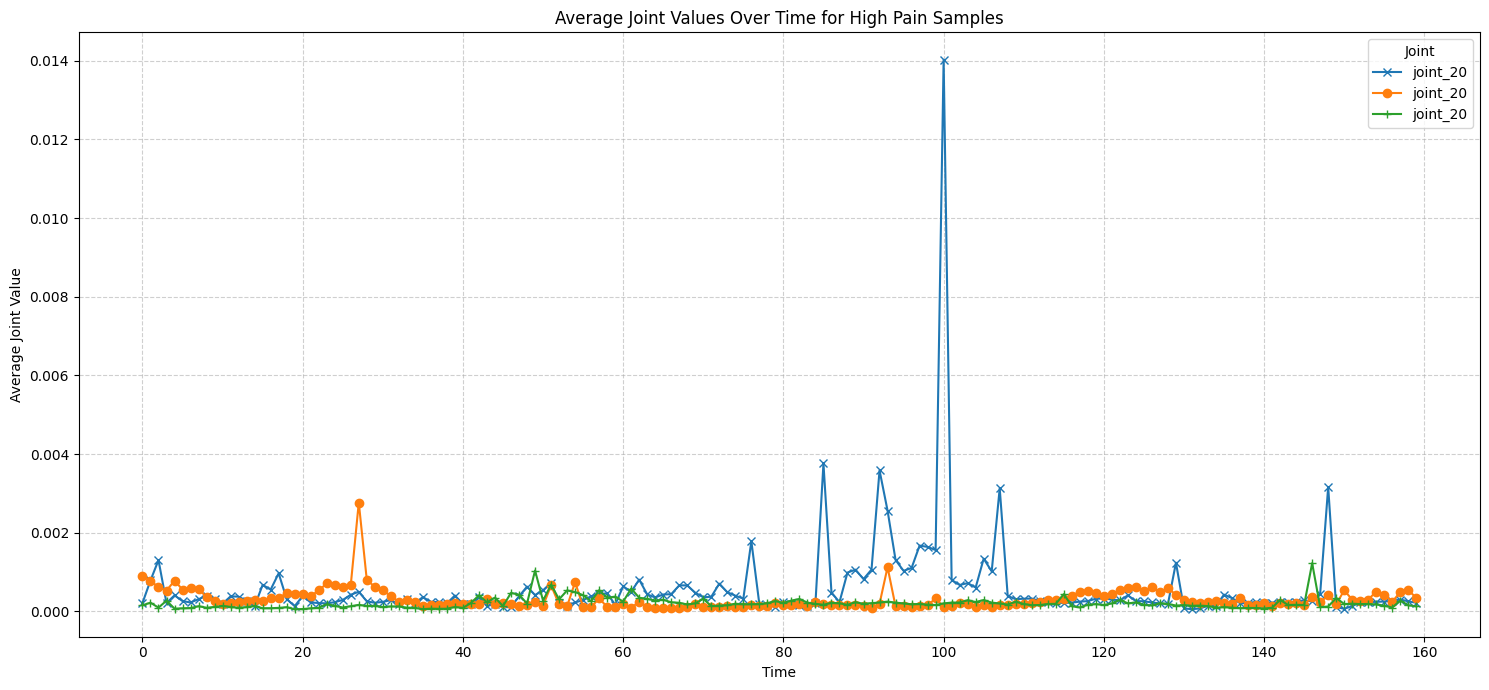

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [ ]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_20']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

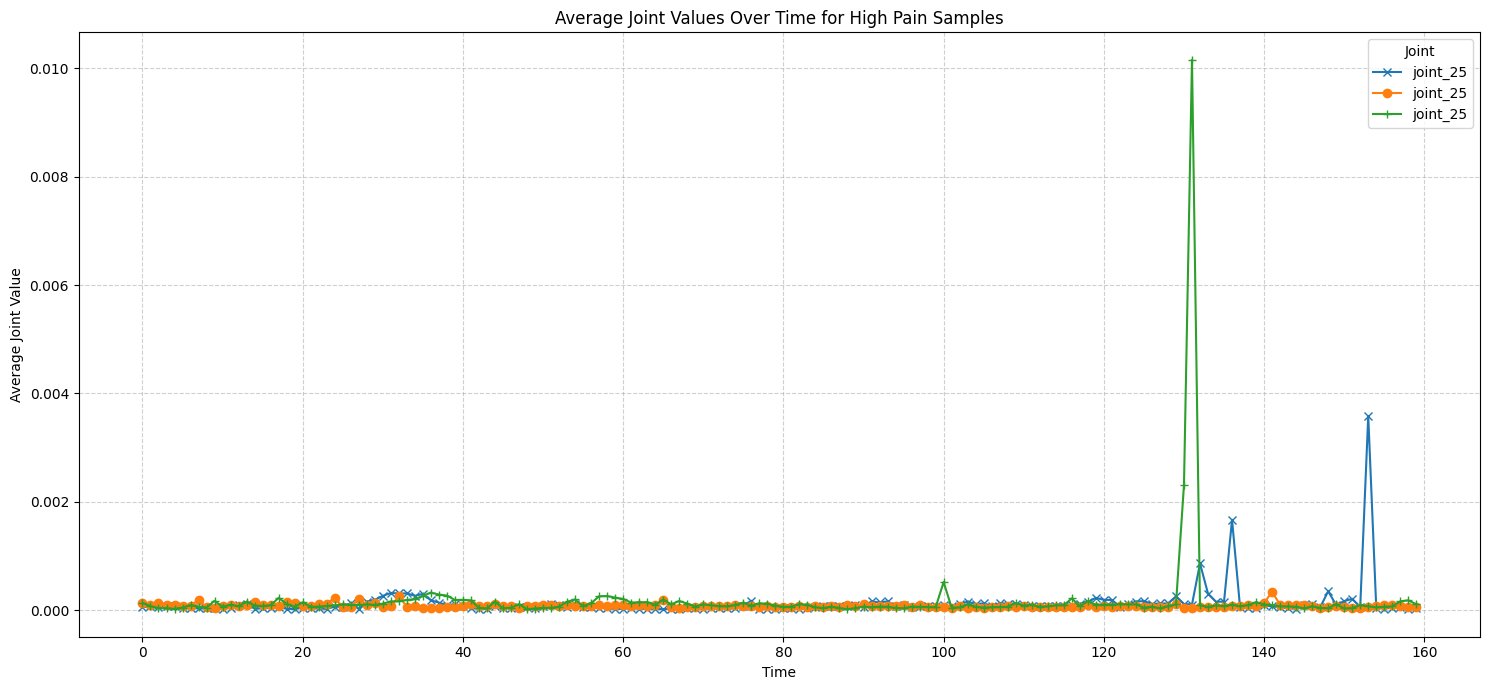

,joint_00,joint_01,joint_02,joint_03,joint_04,joint_05,joint_06,joint_07,joint_08,joint_09,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
time,,,,,,,,,,,,,,,,,,,,,
0,0.931230,0.900431,0.846899,0.819263,0.733561,0.709047,0.896182,0.886287,0.864229,0.885491,...,0.000210,0.000018,0.000017,0.000045,0.000052,0.000059,0.071273,0.093608,0.089075,0.117797
1,0.935739,0.892231,0.836890,0.817762,0.722849,0.704754,0.916305,0.883774,0.873425,0.892415,...,0.000783,0.000030,0.000044,0.000051,0.000041,0.000075,0.074790,0.089319,0.103064,0.126213
2,0.928067,0.895293,0.849300,0.818881,0.723494,0.704637,0.914866,0.882414,0.869627,0.888526,...,0.001301,0.000036,0.000032,0.000061,0.000354,0.000065,0.071808,0.085555,0.105196,0.106004
3,0.938208,0.888046,0.839260,0.817706,0.725062,0.694656,0.910936,0.890046,0.858451,0.876658,...,0.000210,0.000032,0.000021,0.000036,0.000030,0.000081,0.074956,0.082413,0.107101,0.114822
4,0.927242,0.890871,0.845367,0.812352,0.713764,0.698266,0.920420,0.884285,0.865898,0.883751,...,0.000405,0.000058,0.000062,0.000032,0.000039,0.000084,0.075226,0.087802,0.114226,0.112235


In [ ]:
# Select a subset of joints to plot for better readability
# Removed 'joint_30' as it was not present in joint_columns used to create df_high_time_evolution
joints_to_plot = ['joint_25']

plt.figure(figsize=(15, 7))
df_high_time_evolution[joints_to_plot].plot(kind='line', marker='x', ax=plt.gca(), )
df_no_time_evolution[joints_to_plot].plot(kind='line', marker='o', ax=plt.gca())
df_low_time_evolution[joints_to_plot].plot(kind='line', marker='+', ax=plt.gca())
plt.title('Average Joint Values Over Time for High Pain Samples')
plt.xlabel('Time')
plt.ylabel('Average Joint Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Joint')
plt.tight_layout()
plt.show()

display(df_high_time_evolution.head())

In [11]:
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
joint_cols = joint_cols[:-1] # To exclude 'joint_30' as implied by previous usage

survey_corr_matrix = df_train[pain_cols].corr()
joint_corr_matrix = df_train[joint_cols].corr()

print(f"Correlation Matrix for Pain Surveys:\n{survey_corr_matrix}")
print(f"\nCorrelation Matrix for Joints:\n{joint_corr_matrix}")

Correlation Matrix for Pain Surveys:
               pain_survey_1  pain_survey_2  pain_survey_3  pain_survey_4
pain_survey_1       1.000000       0.049383       0.061059       0.035654
pain_survey_2       0.049383       1.000000       0.034670       0.049749
pain_survey_3       0.061059       0.034670       1.000000       0.034950
pain_survey_4       0.035654       0.049749       0.034950       1.000000

Correlation Matrix for Joints:
          joint_00  joint_01  joint_02  joint_03  joint_04  joint_05  \
joint_00  1.000000  0.764235  0.844885  0.706536  0.530988  0.489714   
joint_01  0.764235  1.000000  0.680542  0.817127  0.453518  0.595927   
joint_02  0.844885  0.680542  1.000000  0.834983  0.769236  0.683104   
joint_03  0.706536  0.817127  0.834983  1.000000  0.671963  0.837806   
joint_04  0.530988  0.453518  0.769236  0.671963  1.000000  0.776747   
joint_05  0.489714  0.595927  0.683104  0.837806  0.776747  1.000000   
joint_06  0.291091  0.345411  0.370108  0.415416  0.42837

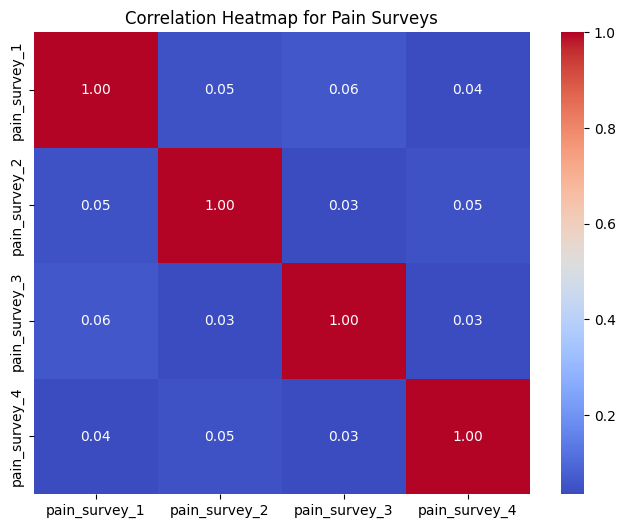

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(survey_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Pain Surveys')
plt.show()

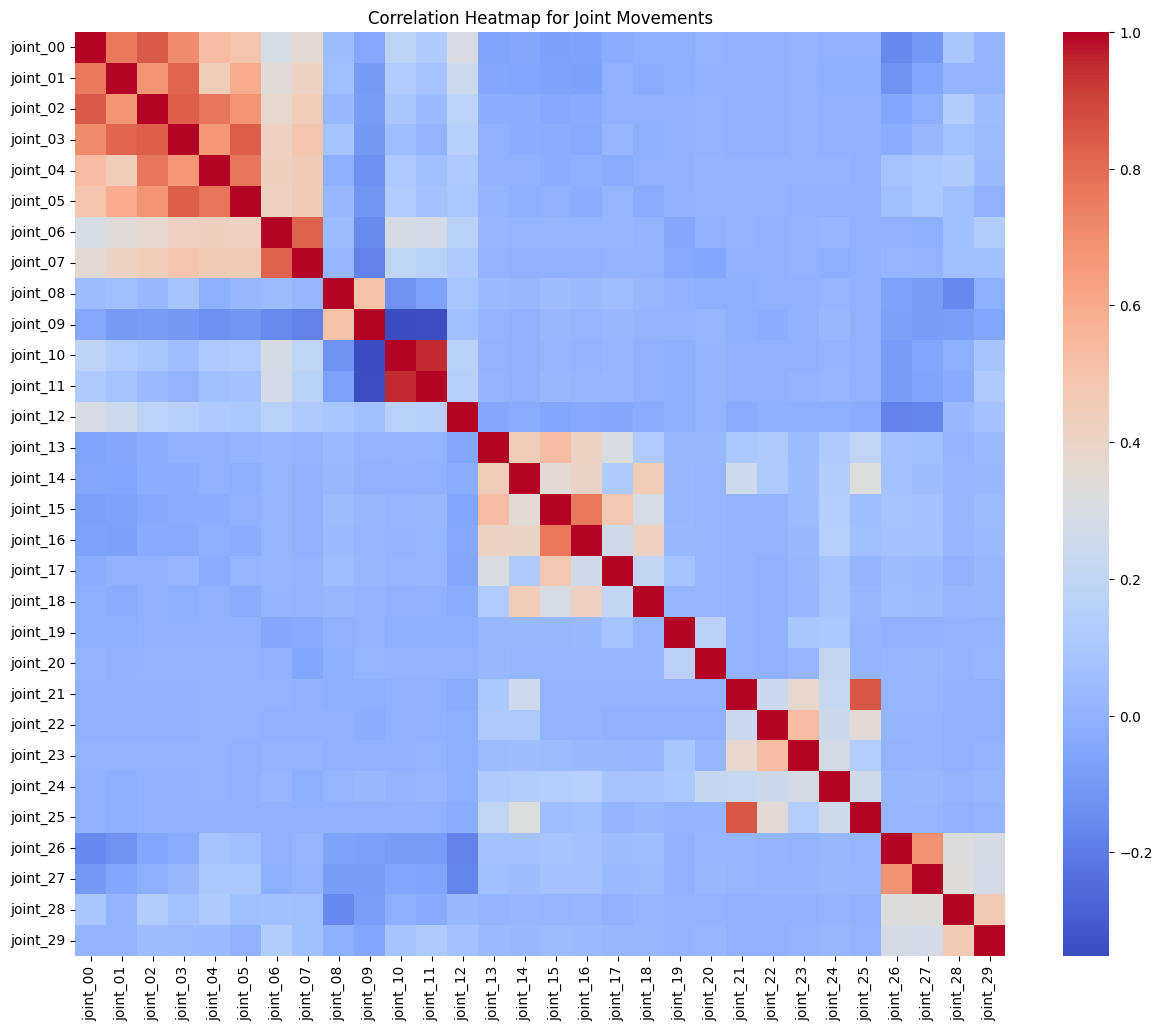

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(joint_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f") # Annotate=False for larger matrices
plt.title('Correlation Heatmap for Joint Movements')
plt.show()

In [14]:
# Set a threshold for high correlation
high_correlation_threshold = 0.8

highly_correlated_pairs = []

# Iterate through the upper triangle of the correlation matrix to avoid duplicates and self-correlation
for i in range(len(joint_corr_matrix.columns)):
    for j in range(i + 1, len(joint_corr_matrix.columns)):
        col1 = joint_corr_matrix.columns[i]
        col2 = joint_corr_matrix.columns[j]
        correlation_value = joint_corr_matrix.loc[col1, col2]

        if abs(correlation_value) >= high_correlation_threshold:
            highly_correlated_pairs.append((col1, col2, correlation_value))

# Sort the pairs by the absolute correlation value in descending order
highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("Highly Correlated Joint Pairs (absolute correlation >= 0.8):")
if highly_correlated_pairs:
    for pair in highly_correlated_pairs:
        print(f"  {pair[0]} - {pair[1]}: {pair[2]:.4f}")
else:
    print("No highly correlated joint pairs found with the current threshold.")

Highly Correlated Joint Pairs (absolute correlation >= 0.8):
  joint_10 - joint_11: 0.9492
  joint_21 - joint_25: 0.8544
  joint_00 - joint_02: 0.8449
  joint_03 - joint_05: 0.8378
  joint_02 - joint_03: 0.8350
  joint_06 - joint_07: 0.8277
  joint_01 - joint_03: 0.8171


In [17]:
joint_cols_remove = ['joint_11', 'joint_25', 'joint_02', 'joint_03', 'joint_07']
joint_cols_selection = [col for col in joint_cols if col not in joint_cols_remove]

Text(0.5, 1.0, 'Correlation Matrix for Selected Columns')

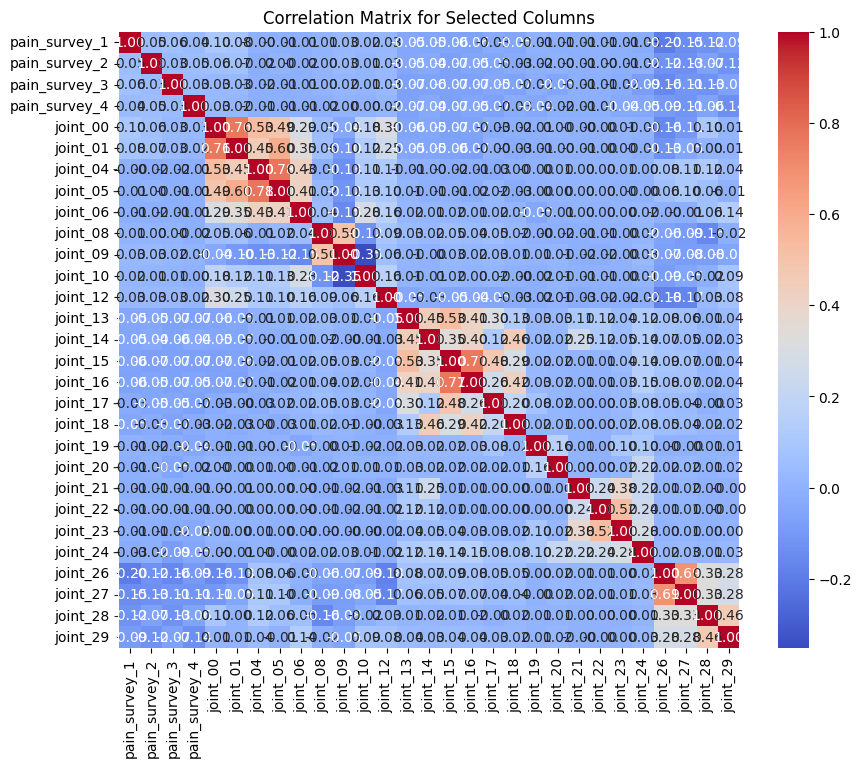

In [18]:
column_selection = pain_cols + joint_cols_selection
corr_matrix = df_train[column_selection].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Columns')

In [20]:
variance_selected_columns = df_train[column_selection].var()
display(variance_selected_columns)

,0
pain_survey_1,4.657018e-01
pain_survey_2,4.484158e-01
pain_survey_3,4.444208e-01
pain_survey_4,4.382365e-01
joint_00,4.082388e-02
joint_01,3.904817e-02
joint_04,1.747759e-01
joint_05,1.695648e-01
joint_06,5.803121e-02
joint_08,3.257601e-02


In [21]:
zero_variance_threshold = 1e-6

columns_with_near_zero_variance = variance_selected_columns[variance_selected_columns < zero_variance_threshold]

print(f"Columns with variance very close to zero (below {zero_variance_threshold}):")
if not columns_with_near_zero_variance.empty:
    display(columns_with_near_zero_variance)
else:
    print("No columns found with variance below the specified threshold.")

Columns with variance very close to zero (below 1e-06):


,0
joint_24,1.650936e-07


--- Plotting a single sample's features ---
Plotting sample_index: 614 (Label: no_pain)


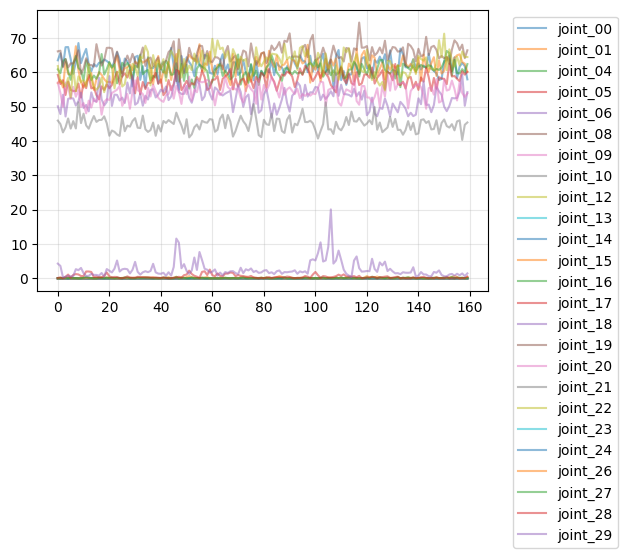

In [32]:
import math

print("--- Plotting a single sample's features ---")

# --- 1. Plot a single time-series sample (Original Code) ---
plot_sid = df_train['sample_index'].sample(n=1).values[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')


# Plot all joint_cols on the first subplot
for col in joint_cols_selection:
    plt.plot(sample_df['time'], sample_df[col] * 180 / math.pi, label=col, alpha=0.5)
plt.grid(alpha=0.3)


# --- RIGHE AGGIUNTE (Metodo avanzato) ---
# Posiziona la legenda fuori dall'area del grafico,
# facendola apparire come una tabella separata a destra.
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# Assicura che la legenda non venga tagliata
plt.tight_layout()

# Se sei in un notebook (come Colab), usa plt.show() alla fine della cella
plt.show()


--- Plotting a single sample's features ---
Plotting sample_index: 209 (Label: no_pain)


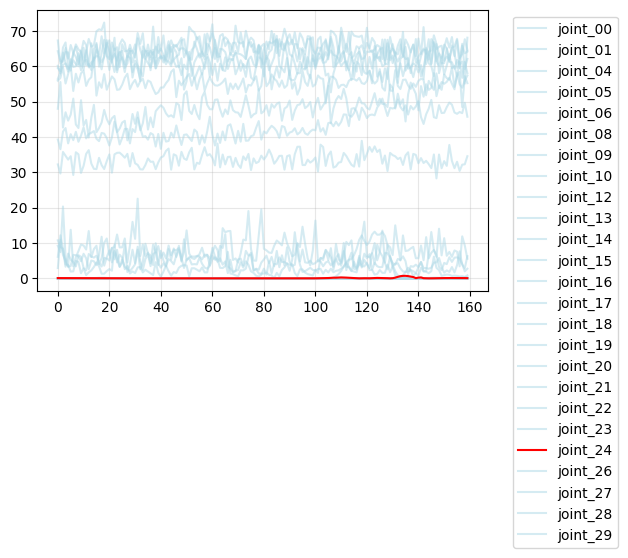

In [33]:
import math
import matplotlib.pyplot as plt

# --- (Il tuo codice per definire df_train, df_labels, ecc.) ---
# Assumiamo che le seguenti variabili siano già definite:
# df_train, df_labels, joint_cols_selection
#
print("--- Plotting a single sample's features ---")

# --- 1. Plot a single time-series sample (Original Code) ---
plot_sid = df_train['sample_index'].sample(n=1).values[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')


# --- BLOCCO MODIFICATO ---
# Plot all joint_cols on the first subplot
for col in joint_cols_selection:
    if col == 'joint_24':
        # Disegna joint_24 in rosso e in primo piano
        plt.plot(sample_df['time'], sample_df[col] * 180 / math.pi,
                 label=col,
                 color='red',
                 zorder=10) # zorder=10 la porta in primo piano
    else:
        # Disegna tutte le altre curve in azzurro chiaro
        plt.plot(sample_df['time'], sample_df[col] * 180 / math.pi,
                 label=col,
                 color='lightblue',
                 alpha=0.5)
# --- FINE BLOCCO MODIFICATO ---

plt.grid(alpha=0.3)

# Posiziona la legenda fuori dall'area del grafico,
# facendola apparire come una tabella separata a destra.
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# Assicura che la legenda non venga tagliata
plt.tight_layout()

# Se sei in un notebook (come Colab), usa plt.show() alla fine della cella
plt.show()

In [34]:
zero_variance_threshold = 1e-5

columns_with_near_zero_variance = variance_selected_columns[variance_selected_columns < zero_variance_threshold]

print(f"Columns with variance very close to zero (below {zero_variance_threshold}):")
if not columns_with_near_zero_variance.empty:
    display(columns_with_near_zero_variance)
else:
    print("No columns found with variance below the specified threshold.")

Columns with variance very close to zero (below 1e-05):


,0
joint_13,1.446252e-06
joint_14,2.190851e-06
joint_15,1.658095e-06
joint_16,2.649489e-06
joint_23,1.525394e-06
joint_24,1.650936e-07


--- Plotting a single sample's features ---
Plotting sample_index: 333 (Label: no_pain)


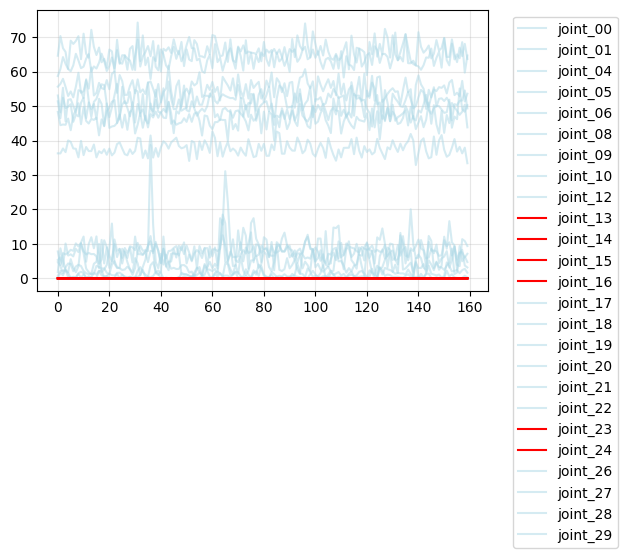

In [35]:
import math
import matplotlib.pyplot as plt

# --- (Il tuo codice per definire df_train, df_labels, ecc.) ---
# Assumiamo che le seguenti variabili siano già definite:
# df_train, df_labels, joint_cols_selection
#
print("--- Plotting a single sample's features ---")

# --- 1. Plot a single time-series sample (Original Code) ---
plot_sid = df_train['sample_index'].sample(n=1).values[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')


# --- BLOCCO MODIFICATO ---
# Plot all joint_cols on the first subplot
for col in joint_cols_selection:
    if col in columns_with_near_zero_variance:
        # Disegna joint_24 in rosso e in primo piano
        plt.plot(sample_df['time'], sample_df[col] * 180 / math.pi,
                 label=col,
                 color='red',
                 zorder=10) # zorder=10 la porta in primo piano
    else:
        # Disegna tutte le altre curve in azzurro chiaro
        plt.plot(sample_df['time'], sample_df[col] * 180 / math.pi,
                 label=col,
                 color='lightblue',
                 alpha=0.5)
# --- FINE BLOCCO MODIFICATO ---

plt.grid(alpha=0.3)

# Posiziona la legenda fuori dall'area del grafico,
# facendola apparire come una tabella separata a destra.
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# Assicura che la legenda non venga tagliata
plt.tight_layout()

# Se sei in un notebook (come Colab), usa plt.show() alla fine della cella
plt.show()

In [38]:
zero_variance_threshold = 1e-5

columns_with_near_zero_variance = variance_selected_columns[variance_selected_columns < zero_variance_threshold].index.tolist()
joint_cols_remove = ['joint_11', 'joint_25', 'joint_02', 'joint_03', 'joint_07'] + columns_with_near_zero_variance

joint_cols_selection = [col for col in joint_cols if col not in joint_cols_remove]
print(joint_cols_selection)

['joint_00', 'joint_01', 'joint_04', 'joint_05', 'joint_06', 'joint_08', 'joint_09', 'joint_10', 'joint_12', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_26', 'joint_27', 'joint_28', 'joint_29']


In [39]:
joint_cols_remove = ['joint_11', 'joint_25', 'joint_02', 'joint_03', 'joint_07']

joint_cols_selection = [col for col in joint_cols if col not in joint_cols_remove]
print(joint_cols_selection)

['joint_00', 'joint_01', 'joint_04', 'joint_05', 'joint_06', 'joint_08', 'joint_09', 'joint_10', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_26', 'joint_27', 'joint_28', 'joint_29']
